#Pré-Processamento de Variáveis

Vistos diferentes tipos de modelos tanto de classificação quanto de regressão e como uni-los para a criação de modelos mais potentes, passamos agora para a otimização desses modelos de modo que eles possuam o maior poder preditivo possível. Existem duas formas de se melhorar a performance de uma modelagem de machine learning: a melhoria do próprio modelo por meio da seleção de seus melhores parâmetros e a melhoria dos dados de entrada do modelo a partir do pré-processamento do conjunto de dados. Este projeto se dedicará a explorar a segunda opção

Para este e para o próximo projeto, nos afastaremos do conjunto de dados de seguro e utilizaremos o conjunto de dados de passageiros do Titanic. O objetivo será prever da melhor forma possível quais passageiros sobreviveram e quais não sobreviveram à tragédia (variável **Survived**)

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from google.colab.data_table import DataTable

Sendo este um conjunto de dados do Kaggle, plataforma de competições de ciência de dados, os conjuntos de teste e treinamento já estão separados. Como a variável **Survived** do conjunto de teste é a que se deseja prever, seus valores não estão presentes no arquivo disponível ao público

In [ ]:
url1 = 'https://raw.githubusercontent.com/ricardorocha86/Datasets/master/Titanic/train.csv'
url2 = 'https://raw.githubusercontent.com/ricardorocha86/Datasets/master/Titanic/test.csv'

titanic = pd.read_csv(url1)
teste = pd.read_csv(url2)

In [ ]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
teste.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


##Análise Exploratória de Dados Básica

Podemos usar a biblioteca Sweetviz para fazermos uma análise exploratória básica dos dados

In [ ]:
!pip install sweetviz

In [ ]:
import sweetviz

In [ ]:
eda_titanic = sweetviz.analyze(titanic)
eda_titanic.show_html()

Procuramos então padrões discriminando a variável alvo em vítimas e sobreviventes

In [ ]:
eda2 = sweetviz.compare_intra(titanic, titanic['Survived'] == 0, ['Vítima', 'Sobrevivente'])
eda2.show_html()

###Heurística

A heurística é uma solução para o problema que parte de uma premissa simples. O número de acertos retornado pela heurística serve como base para avaliarmos nossos modelos na medida em que qualquer modelo posterior só será relevante se ele se sair melhor do que ela

Nete projeto, determinamos a heurística como "toda mulher sobrevive, todo homem não sobrevive"

In [ ]:
teste1 = titanic['Sex'].map({'male': 0, 'female': 1})

(teste1 == titanic['Survived']).mean().round(4)

0.7868

##Pré-Processamento

Todas as alterações de pré-processamento devem ser feitas no conjunto de dados de teste e no conjunto de treinamento

###Descartando Variáveis

De acordo com os resultados obtidos pela análise exploratória, podemos descartar variáveis do conjunto de dados que parecem não ser importantes para a previsão que desejamos fazer

In [ ]:
titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
teste.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [ ]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
teste.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


###Dados Incompletos ou Faltantes

Determinadas as variáveis que desejamos manter, podemos verificar quais são os valores que estão ausentes no conjunto de dados e elaborar uma forma de preenchê-los

VERIFICANDO DADOS FALTANTES

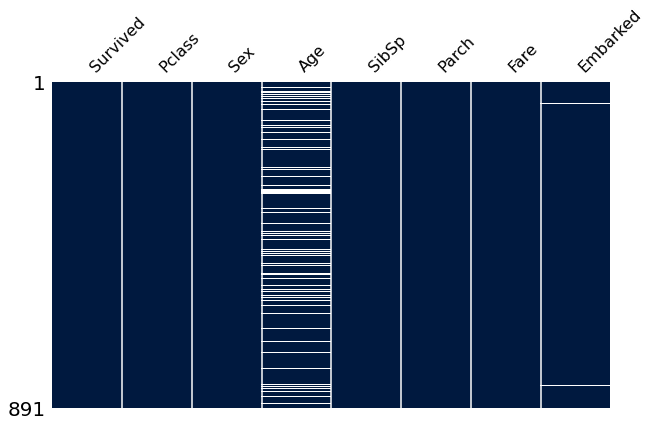

In [ ]:
msno.matrix(titanic, figsize = (10, 6), color = (0, 0.1, 0.25), sparkline = False)

In [ ]:
titanic.isnull().mean()

Survived    0.000000
Pclass      0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Embarked    0.002245
dtype: float64

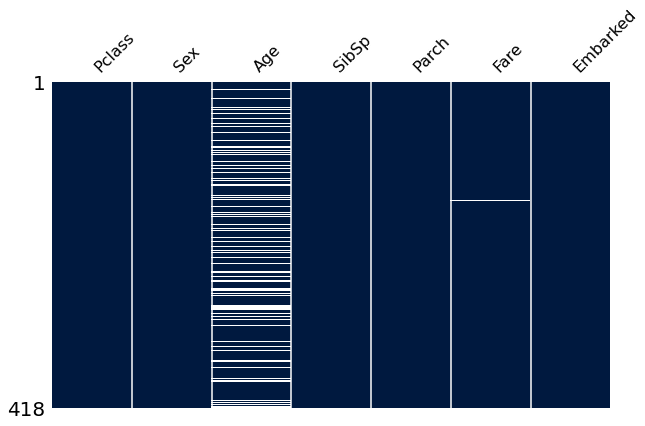

In [ ]:
msno.matrix(teste, figsize = (10, 6), color = (0, 0.1, 0.25), sparkline = False)

In [ ]:
teste.isnull().mean()

Pclass      0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Fare        0.002392
Embarked    0.000000
dtype: float64

PREENCHENDO DADOS FALTANTES

Neste projeto, optou-se por preencher os dados faltantes das variáveis **Age** e **Fare** com suas respectivas medianas e a variável **Embarked** com sua moda

In [ ]:
med_age = titanic['Age'].median()
med_fare = titanic['Fare'].median()
med_emb = titanic['Embarked'].mode()[0]

In [ ]:
titanic['Age'] = titanic['Age'].fillna(med_age)
titanic['Fare'] = titanic['Fare'].fillna(med_fare)
titanic['Embarked'] = titanic['Embarked'].fillna(med_emb)

In [ ]:
titanic.isnull().mean()

Survived    0.0
Pclass      0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Embarked    0.0
dtype: float64

Como os dados de teste devem permanecer desconhecidos para não prejudicar o poder de previsão de nosso algoritmo, preenchemos seus dados faltantes com os valores de mediana e moda obtidos no conjunto de treinamento

In [ ]:
teste['Age'] = teste['Age'].fillna(med_age)
teste['Fare'] = teste['Fare'].fillna(med_fare)
teste['Embarked'] = teste['Embarked'].fillna(med_emb)

In [ ]:
teste.isnull().mean()

Pclass      0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Embarked    0.0
dtype: float64

###Codificando as Variáveis Categóricas

Parte importante do pré-processamento é a codificação das variáveis categóricas, ou seja, sua transformação em valores numéricos. Este processo é importante para garantir que o modelo possa utilizar as informações nelas contidas para fazer suas previsões

No caso da variável **Sex**, que possui apenas duas categorias, podemos transformá-la em uma variável binária atribuindo os valores 0 ou 1 a cada uma delas. Neste projeto, ao sexo feminino foi atribuído o valor 1 e ao masculino, o 0

In [ ]:
titanic['Sex'] = titanic['Sex'].map({'male': 0, 'female': 1})
teste['Sex'] = teste['Sex'].map({'male': 0, 'female': 1})

Já para variáveis como **Embarked** e **Pclass**, que possuem mais de duas categorias, a solução é fazer sua dummificação. No processo de dummificação, são criadas k colunas de acordo com o número de categorias da variável e, para cada coluna, é atribuído um valor 0 ou 1 dependendo da categoria que a variável assume em cada entrada

In [ ]:
titanic = pd.get_dummies(titanic, columns = ['Embarked', 'Pclass'])
teste = pd.get_dummies(teste, columns = ['Embarked', 'Pclass'])

In [ ]:
titanic.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,0,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1,1,0,0
4,0,0,35.0,0,0,8.0500,0,0,1,0,0,1


In [ ]:
teste.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,34.5,0,0,7.8292,0,1,0,0,0,1
1,1,47.0,1,0,7.0000,0,0,1,0,0,1
2,0,62.0,0,0,9.6875,0,1,0,0,1,0
3,0,27.0,0,0,8.6625,0,0,1,0,0,1
4,1,22.0,1,1,12.2875,0,0,1,0,0,1


###Mudando a Escala das Variáveis Contínuas

Outra forma de facilitar o processamento dos dados feito pelos algoritmos de machine learning é por meio do escalonamento das variáveis, ou seja, por meio do ajuste de sua escala para que os dados assumam valores mais próximos entre si. Quanto mais próximo de média 0 e desvio padrão 1, melhor para a modelagem

Uma forma de fazer o escalonamento das variáveis é por padronização:


> (vetor - sua média) / seu desvio padrão

Utilizando a função Standard Scaler, ajustamos a transformação nos dados de treinamento e utilizamos o mesmo ajuste também nos dados de teste

In [ ]:
sc = StandardScaler()

In [ ]:
aux0 = sc.fit_transform(titanic[['Age', 'Fare']])
aux1 = pd.DataFrame(aux0, columns = ['Idade', 'Tarifa'])
titanic = pd.concat([titanic, aux1], axis = 1)

titanic.drop(['Age', 'Fare'], axis = 1, inplace = True)

In [ ]:
titanic.head()

,Survived,Sex,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa
0,0,0,1,0,0,0,1,0,0,1,-0.565736,-0.502445
1,1,1,1,0,1,0,0,1,0,0,0.663861,0.786845
2,1,1,0,0,0,0,1,0,0,1,-0.258337,-0.488854
3,1,1,1,0,0,0,1,1,0,0,0.433312,0.420730
4,0,0,0,0,0,0,1,0,0,1,0.433312,-0.486337


In [ ]:
aux0 = sc.transform(teste[['Age', 'Fare']])
aux1 = pd.DataFrame(aux0, columns = ['Idade', 'Tarifa'])
teste = pd.concat([teste, aux1], axis = 1)

teste.drop(['Age', 'Fare'], axis = 1, inplace = True)

In [ ]:
teste.head()

,Sex,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa
0,0,0,0,0,1,0,0,0,1,0.394887,-0.490783
1,1,1,0,0,0,1,0,0,1,1.355510,-0.507479
2,0,0,0,0,1,0,0,1,0,2.508257,-0.453367
3,0,0,0,0,0,1,0,0,1,-0.181487,-0.474005
4,1,1,1,0,0,1,0,0,1,-0.565736,-0.401017


##CHECKPOINT 1

Guardamos as alterações feitas no conjunto de dados até então. Assim, podemos testar o desempenho do modelo com os dados modificados em diversos pontos do pré-processamento

In [ ]:
titanic1 = titanic.copy()
teste1 = teste.copy()

###Engenharia de Variáveis

Engenharia de variáveis é o processo pelo qual criamos novas variáveis ao alterarmos variáveis já existentes do conjunto de dados e deixarmos algumas de suas informações mais evidentes para serem utilizadas pelo modelo

####Variável "Sozinho"

Para criarmos uma variável que indica se um passageiro estava ou não sozinho no navio, contabilizamos quantos outros passageiros estavam com ele (incluindo ele mesmo). Se esse valor for 1, significa que ele estava sozinho. Senão, significa que ele estava acompanhado

In [ ]:
titanic['Família'] = titanic['SibSp'] + titanic['Parch'] + 1
teste['Família'] = teste['SibSp'] + teste['Parch'] + 1

In [ ]:
titanic.head()

,Survived,Sex,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa,Família
0,0,0,1,0,0,0,1,0,0,1,-0.565736,-0.502445,2
1,1,1,1,0,1,0,0,1,0,0,0.663861,0.786845,2
2,1,1,0,0,0,0,1,0,0,1,-0.258337,-0.488854,1
3,1,1,1,0,0,0,1,1,0,0,0.433312,0.420730,2
4,0,0,0,0,0,0,1,0,0,1,0.433312,-0.486337,1


In [ ]:
teste.head()

,Sex,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa,Família
0,0,0,0,0,1,0,0,0,1,0.394887,-0.490783,1
1,1,1,0,0,0,1,0,0,1,1.355510,-0.507479,2
2,0,0,0,0,1,0,0,1,0,2.508257,-0.453367,1
3,0,0,0,0,0,1,0,0,1,-0.181487,-0.474005,1
4,1,1,1,0,0,1,0,0,1,-0.565736,-0.401017,3


In [ ]:
def aux(x):
  if x == 1:
    return 1
  else: 
    return 0

titanic['Sozinho'] = titanic['Família'].apply(aux)
teste['Sozinho'] = teste['Família'].apply(aux)

In [ ]:
titanic.drop(['SibSp', 'Parch', 'Família'], axis = 1, inplace = True)
teste.drop(['SibSp', 'Parch', 'Família'], axis = 1, inplace = True)

In [ ]:
titanic.head()

,Survived,Sex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa,Sozinho
0,0,0,0,0,1,0,0,1,-0.565736,-0.502445,0
1,1,1,1,0,0,1,0,0,0.663861,0.786845,0
2,1,1,0,0,1,0,0,1,-0.258337,-0.488854,1
3,1,1,0,0,1,1,0,0,0.433312,0.420730,0
4,0,0,0,0,1,0,0,1,0.433312,-0.486337,1


In [ ]:
teste.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa,Sozinho
0,0,0,1,0,0,0,1,0.394887,-0.490783,1
1,1,0,0,1,0,0,1,1.355510,-0.507479,0
2,0,0,1,0,0,1,0,2.508257,-0.453367,1
3,0,0,0,1,0,0,1,-0.181487,-0.474005,1
4,1,0,0,1,0,0,1,-0.565736,-0.401017,0


Podemos verificar que tipo de informação a variável criada oferece em relação à variável que desejamos prever

In [ ]:
titanic['Sozinho'].groupby(titanic['Survived']).mean()

Survived
0    0.681239
1    0.476608
Name: Sozinho, dtype: float64

####Variável "Titulação"

Podemos observar que na variável **Name** o nome de cada passageiro também apresenta seu título. É possível extrairmos somente essa informação da variável e adicioná-la ao modelo

In [ ]:
url = 'https://raw.githubusercontent.com/ricardorocha86/Datasets/master/Titanic/train.csv' 
nome = pd.read_csv(url, usecols = ['Name'] )   

titulacao = []
for i in range(nome.shape[0]):
    titulacao.append(nome.iloc[i,0].split(', ')[1].split('. ')[0])

tt = []
for i in range(nome.shape[0]):
    if titulacao[i] in ['Mr', 'Miss', 'Mrs', 'Master']:
        tt.append(titulacao[i])
    else:
        tt.append('Outros')

titanic['Titulo'] = tt

In [ ]:
titanic.head()

,Survived,Sex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa,Sozinho,Titulo
0,0,0,0,0,1,0,0,1,-0.565736,-0.502445,0,Mr
1,1,1,1,0,0,1,0,0,0.663861,0.786845,0,Mrs
2,1,1,0,0,1,0,0,1,-0.258337,-0.488854,1,Miss
3,1,1,0,0,1,1,0,0,0.433312,0.420730,0,Mrs
4,0,0,0,0,1,0,0,1,0.433312,-0.486337,1,Mr


In [ ]:
url = 'https://raw.githubusercontent.com/ricardorocha86/Datasets/master/Titanic/test.csv' 
nome = pd.read_csv(url, usecols = ['Name'] )   

titulacao = []
for i in range(nome.shape[0]):
    titulacao.append(nome.iloc[i,0].split(', ')[1].split('. ')[0])

tt = []
for i in range(nome.shape[0]):
    if titulacao[i] in ['Mr', 'Miss', 'Mrs', 'Master']:
        tt.append(titulacao[i])
    else:
        tt.append('Outros')

teste['Titulo'] = tt

In [ ]:
teste.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa,Sozinho,Titulo
0,0,0,1,0,0,0,1,0.394887,-0.490783,1,Mr
1,1,0,0,1,0,0,1,1.355510,-0.507479,0,Mrs
2,0,0,1,0,0,1,0,2.508257,-0.453367,1,Mr
3,0,0,0,1,0,0,1,-0.181487,-0.474005,1,Mr
4,1,0,0,1,0,0,1,-0.565736,-0.401017,0,Mrs


Podemos verificar que tipo de informação a variável criada fornece em relação à variável que desejamos prever

In [ ]:
titanic['Survived'].groupby(titanic['Titulo']).describe().sort_values(by = 'count', ascending = False)

,count,mean,std,min,25%,50%,75%,max
Titulo,,,,,,,,
Mr,517.0,0.156673,0.363844,0.0,0.0,0.0,0.0,1.0
Miss,182.0,0.697802,0.460477,0.0,0.0,1.0,1.0,1.0
Mrs,125.0,0.792000,0.407510,0.0,1.0,1.0,1.0,1.0
Master,40.0,0.575000,0.500641,0.0,0.0,1.0,1.0,1.0
Outros,27.0,0.444444,0.506370,0.0,0.0,0.0,1.0,1.0


Para incluir a nova variável no modelo, devemos dummificá-la para que ela passe a assumir valores numéricos

In [ ]:
titanic = pd.get_dummies(titanic, columns = ['Titulo'])
teste = pd.get_dummies(teste, columns = ['Titulo'])

In [ ]:
titanic.head()

,Survived,Sex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa,Sozinho,Titulo_Master,Titulo_Miss,Titulo_Mr,Titulo_Mrs,Titulo_Outros
0,0,0,0,0,1,0,0,1,-0.565736,-0.502445,0,0,0,1,0,0
1,1,1,1,0,0,1,0,0,0.663861,0.786845,0,0,0,0,1,0
2,1,1,0,0,1,0,0,1,-0.258337,-0.488854,1,0,1,0,0,0
3,1,1,0,0,1,1,0,0,0.433312,0.420730,0,0,0,0,1,0
4,0,0,0,0,1,0,0,1,0.433312,-0.486337,1,0,0,1,0,0


In [ ]:
teste.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Idade,Tarifa,Sozinho,Titulo_Master,Titulo_Miss,Titulo_Mr,Titulo_Mrs,Titulo_Outros
0,0,0,1,0,0,0,1,0.394887,-0.490783,1,0,0,1,0,0
1,1,0,0,1,0,0,1,1.355510,-0.507479,0,0,0,0,1,0
2,0,0,1,0,0,1,0,2.508257,-0.453367,1,0,0,1,0,0
3,0,0,0,1,0,0,1,-0.181487,-0.474005,1,0,0,1,0,0
4,1,0,0,1,0,0,1,-0.565736,-0.401017,0,0,0,0,1,0


##CHECKPOINT 2

Guardamos novamente as alterações feitas até então

In [ ]:
titanic2 = titanic.copy()
teste2 = teste.copy()

##Aplicando nos Modelos de Machine Learning

In [ ]:
X = titanic.drop('Survived', axis = 1)
y = titanic['Survived']

Para o processo de validação, utilizaremos o K-FOLD estratificado. Este é o processo K-FOLD mantendo-se nas amostragens a proporção na variável resposta

In [ ]:
kf = StratifiedKFold(n_splits = 10)

In [ ]:
def MachineLearning(dataset):
  X = dataset.drop('Survived', axis = 1)
  y = dataset['Survived']

  lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']
  nome_das_medidas = ['acurácia', 'sensibilidade', 'vpp', 'eficiência', 'f1-score']

  lista_de_modelos = [LogisticRegression(),
                      DecisionTreeClassifier(max_depth = 3),
                      DecisionTreeClassifier(max_depth = 5),
                      DecisionTreeClassifier(max_depth = 7),
                      KNeighborsClassifier(n_neighbors = 5),
                      KNeighborsClassifier(n_neighbors = 15),
                      KNeighborsClassifier(n_neighbors = 25),
                      BaggingClassifier(),
                      RandomForestClassifier(n_estimators = 300, max_depth = 3, max_features = 3),
                      RandomForestClassifier(n_estimators = 300, max_depth = 3, max_features = 4),
                      RandomForestClassifier(n_estimators = 300, max_depth = 6, max_features = 3),
                      RandomForestClassifier(n_estimators = 300, max_depth = 6, max_features = 4)]
  
  nome_dos_modelos = ['Regressão Logística',
                        'Árvore (prof = 3)',
                        'Árvore (prof = 5)',
                        'Árvore (prof = 7)',
                        '5-NN',
                        '15-NN',
                        '25-NN',
                        'Bagging',
                        'Random Forest (prof = 3, mf = 3)',
                        'Random Forest (prof = 3, mf = 4)',
                        'Random Forest (prof = 6, mf = 3)',
                        'Random Forest (prof = 6, mf = 4)']
  
  resultados0 = {}

  for i in range(len(lista_de_modelos)):
    print('Rodando modelo: ' + nome_dos_modelos[i])
    accs_vc = cross_validate(lista_de_modelos[i], X, y, cv = kf, scoring = lista_de_medidas)
    
    acc = accs_vc['test_accuracy'].mean().round(4)
    sen = accs_vc['test_recall'].mean().round(4)
    vpp = accs_vc['test_precision'].mean().round(4)
    bac = accs_vc['test_balanced_accuracy'].mean().round(4)
    f1s = accs_vc['test_f1'].mean().round(4)

    resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, f1s, bac]

  resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

  return resultados

Utilizamos então os dados guardados nos Cenários 1 e 2 para verificarmos o poder preditivo dos modelos levando em conta dados fornecidos em diferentes etapas do pré-processamento

In [ ]:
resultados1 = MachineLearning(titanic1)
DataTable(resultados1)

Rodando modelo: Regressão Logística
Rodando modelo: Árvore (prof = 3)
Rodando modelo: Árvore (prof = 5)
Rodando modelo: Árvore (prof = 7)
Rodando modelo: 5-NN
Rodando modelo: 15-NN
Rodando modelo: 25-NN
Rodando modelo: Bagging
Rodando modelo: Random Forest (prof = 3, mf = 3)
Rodando modelo: Random Forest (prof = 3, mf = 4)
Rodando modelo: Random Forest (prof = 6, mf = 3)
Rodando modelo: Random Forest (prof = 6, mf = 4)


,acurácia,sensibilidade,vpp,eficiência,f1-score
Regressão Logística,0.7991,0.6987,0.7611,0.7255,0.7802
Árvore (prof = 3),0.8159,0.7044,0.7947,0.7425,0.7948
Árvore (prof = 5),0.8037,0.6724,0.7878,0.7205,0.7788
Árvore (prof = 7),0.8194,0.6754,0.8252,0.7389,0.7921
5-NN,0.8059,0.7194,0.7623,0.7380,0.7896
15-NN,0.7857,0.6467,0.7601,0.6958,0.7596
25-NN,0.8003,0.6552,0.7913,0.7145,0.7730
Bagging,0.8093,0.7048,0.7785,0.7368,0.7896
"Random Forest (prof = 3, mf = 3)",0.8014,0.5790,0.8559,0.6892,0.7595
"Random Forest (prof = 3, mf = 4)",0.8193,0.6286,0.8608,0.7245,0.7833


In [ ]:
resultados2 = MachineLearning(titanic2)
DataTable(resultados2)

Rodando modelo: Regressão Logística
Rodando modelo: Árvore (prof = 3)
Rodando modelo: Árvore (prof = 5)
Rodando modelo: Árvore (prof = 7)
Rodando modelo: 5-NN
Rodando modelo: 15-NN
Rodando modelo: 25-NN
Rodando modelo: Bagging
Rodando modelo: Random Forest (prof = 3, mf = 3)
Rodando modelo: Random Forest (prof = 3, mf = 4)
Rodando modelo: Random Forest (prof = 6, mf = 3)
Rodando modelo: Random Forest (prof = 6, mf = 4)


,acurácia,sensibilidade,vpp,eficiência,f1-score
Regressão Logística,0.8092,0.7308,0.7619,0.7442,0.7944
Árvore (prof = 3),0.8238,0.7247,0.7980,0.7561,0.8050
Árvore (prof = 5),0.8194,0.7167,0.7906,0.7485,0.8001
Árvore (prof = 7),0.8205,0.7077,0.7996,0.7485,0.7992
5-NN,0.8171,0.7368,0.7770,0.7536,0.8019
15-NN,0.8048,0.6726,0.7893,0.7224,0.7798
25-NN,0.8003,0.6317,0.8094,0.7064,0.7685
Bagging,0.8070,0.7076,0.7750,0.7360,0.7883
"Random Forest (prof = 3, mf = 3)",0.8002,0.7161,0.7507,0.7307,0.7843
"Random Forest (prof = 3, mf = 4)",0.8036,0.7132,0.7601,0.7330,0.7864


#Considerações Finais

Neste projeto, observamos alguns procedimentos de pré-processamento realizados com o intuito de se obter uma melhor performance em nossos modelos de previsão. Apesar de os procedimentos realizados não esgotarem as possibilidades de pré-processamento, foram apresentados conceitos indispensáveis, como dummificação, descarte e escalonamento de variáveis, bem como verificação de dados faltantes. Problemas e conjuntos de dados diferentes exigem pré-processamentos distintos, e que só poderão ser avaliados após o ajuste e avaliação do modelo. Nesta etapa, deve-se buscar o modelo e seu respectivo conjunto de parâmetros que, alimentados com os dados tratados, melhor se adequam ao problema que se deseja resolver